- http://localhost:8888/notebooks/git/blnd/nbs/DevCropResize0703.ipynb
- http://localhost:8888/notebooks/git/blnd/nbs/Prep0703.ipynb

# start

In [8]:
PRFX = 'MelEda0628A1'
PRFX_PREP = 'MelPrp0626A2'

# setup

In [67]:
from pathlib import Path
import pickle
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from collections import defaultdict, Counter

# eda

In [10]:
p_cmp = '../input/siim-isic-melanoma-classification/'
p_prp = f'../output/{PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
dftst = pd.read_csv(f'{p_cmp}/test.csv')

In [11]:
dftrn.shape

(58457, 4)

In [12]:
dftst.shape

(10982, 5)

In [13]:
dftrn.head()

,source,im_pth,patient_id,target
0,20,../input/siim-isic-melanoma-classification/jpe...,IP_7279968,0.0
1,20,../input/siim-isic-melanoma-classification/jpe...,IP_3075186,0.0
2,20,../input/siim-isic-melanoma-classification/jpe...,IP_2842074,0.0
3,20,../input/siim-isic-melanoma-classification/jpe...,IP_6890425,0.0
4,20,../input/siim-isic-melanoma-classification/jpe...,IP_8723313,0.0


In [14]:
dftst.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


## train set imgs

In [15]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


/data/anaconda3/envs/mel/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


- A part of the training dataset is the HAM10 0 0 0 dataset which contains images of size 600 ×450 that were centered and cropped around the lesion. 
- The dataset curators applied histogram corrections to some images [1] . 
- Another dataset, BCN_20 0 0 0, contains images of size 1024 ×1024. This dataset is particularly challenging as many images are uncropped and lesions in difficult and uncommon locations are present [2] . 
- Last, the MSK dataset contains images with various sizes.

In [16]:
dftrn['ds']=dftrn.patient_id.apply(lambda x: x.split('_')[0])
dftrn.ds.value_counts()

IP      33126
BCN     12413
HAM     10015
Nan      2084
MSK4      819
Name: ds, dtype: int64

In [17]:
dftrn.sample()

,source,im_pth,patient_id,target,ds
17960,20,../input/siim-isic-melanoma-classification/jpe...,IP_9180273,0.0,IP


In [18]:
dftrn.groupby('ds').target.mean()

ds
BCN     0.230162
HAM     0.111133
IP      0.017630
MSK4    0.262515
Nan     0.161708
Name: target, dtype: float64

## test set imgs

In [19]:
dftst['im_pth']=f'{p_cmp}/jpeg/test/'+dftst.image_name+'.jpg'

## crop

In [20]:
dss = dftrn.ds.unique()
dss

array(['IP', 'Nan', 'MSK4', 'HAM', 'BCN'], dtype=object)

In [ ]:
for ds in ['BCN']:
    print(ds)
    fnms = np.random.choice(dftrn[dftrn.ds==ds].im_pth, 20, replace=False)
    for fnm in fnms:
        print(fnm)
        img = plt.imread(fnm)
        plt.title(f'{ds} {img.shape}')
        plt.imshow(img)
        plt.show()
    print('*'*50)

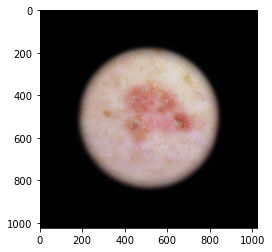

In [105]:
# fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0054193.jpg'
fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0073022.jpg'
# fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0067759.jpg'
# fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065728.jpg'
# fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0063952.jpg'
# fnm = '../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070074.jpg'
img0_pil = Image.open(fnm)
plt.imshow(img0_pil);

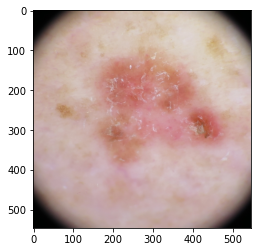

In [106]:
image = cv2.imread(fnm)

keep_less=0.80
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=cv2.contourArea)
((x, y), r) = cv2.minEnclosingCircle(cnt)
r = r*keep_less
x = int(x); y = int(y); r = int(r)
output = output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)]
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output);

In [107]:
fnm_new = fnm.replace('../input', 'tmp')
fnm_new

'tmp/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0073022.jpg'

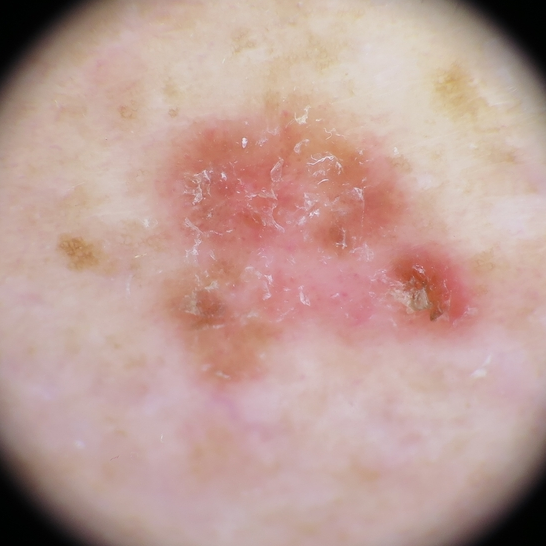

In [108]:
im_pil = Image.fromarray(output)
im_pil

In [109]:
im_pil.save(fnm_new)

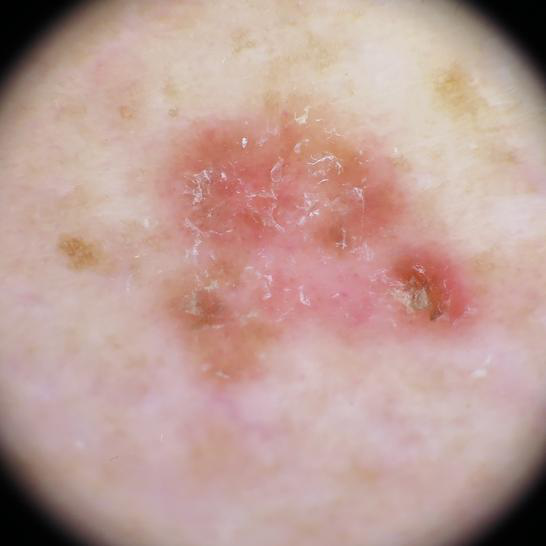

In [110]:
Image.open(fnm_new)